<a href="https://colab.research.google.com/github/PrathibhaNishadi/Ride-fare-Classification/blob/master/ML_RF_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reading the input train and test files

In [149]:
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import numpy as np # linear algebra
import pandas as pd # CSV file I/O (e.g. pd.read_csv)
import os

pd.set_option("display.max_columns", 100)

from google.colab import drive
drive.mount('/content/gdrive')
DATA_PATH = "/content/gdrive/My Drive/RideFareData/"

train_df = pd.read_csv(
    DATA_PATH + "train.csv", 
    index_col="tripid"
)
test_df = pd.read_csv(
    DATA_PATH + "test.csv", 
    index_col="tripid"
)
print("train_df.shape", train_df.shape)

print("test_df.shape", test_df.shape)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
train_df.shape (17176, 13)
test_df.shape (8576, 12)


viewing the relevence of features using correlation matrix

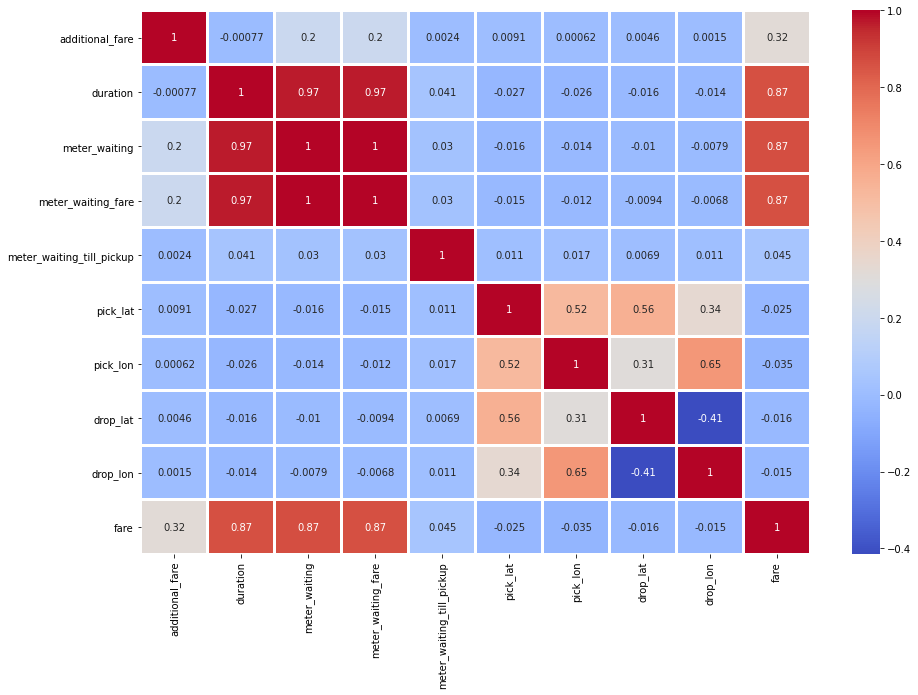

In [150]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
sns.heatmap(train_df.corr(),cmap='coolwarm',ax=ax,annot=True,linewidths=2)

Mapping the labels into numerical value

In [128]:
train_df["label"] = train_df["label"].map({"incorrect": 0, "correct":1})

Get the time spent for a ride

In [129]:
train_df["pickup_time"] = pd.to_datetime(train_df["pickup_time"])
train_df["drop_time"] = pd.to_datetime(train_df["drop_time"])

train_df ['difference'] = train_df["drop_time"] - train_df["pickup_time"]   #time difference between the two stops
train_df ['difference'] = train_df ['difference']/np.timedelta64(1,'s')


In [4]:
train_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17176 entries, 189123628 to 213817296
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   additional_fare            16974 non-null  float64       
 1   duration                   16974 non-null  float64       
 2   meter_waiting              16974 non-null  float64       
 3   meter_waiting_fare         16974 non-null  float64       
 4   meter_waiting_till_pickup  16974 non-null  float64       
 5   pickup_time                17176 non-null  datetime64[ns]
 6   drop_time                  17176 non-null  datetime64[ns]
 7   pick_lat                   17176 non-null  float64       
 8   pick_lon                   17176 non-null  float64       
 9   drop_lat                   17176 non-null  float64       
 10  drop_lon                   17176 non-null  float64       
 11  fare                       17039 non-null  float64     

Filling the missing values in the training set

In [130]:
train_df['duration'] = train_df['duration'].fillna(train_df ['difference']) #duration = time difference; filled the missing values with the real difference

In [131]:
## take the mean for the missing values

train_df['additional_fare'] = train_df['additional_fare'] .fillna(train_df.additional_fare.mean())
train_df['meter_waiting'] = train_df['meter_waiting'] .fillna(train_df.meter_waiting.mean())
train_df['meter_waiting_fare'] = train_df['meter_waiting_fare'] .fillna(train_df.meter_waiting_fare.mean())
train_df['meter_waiting_till_pickup'] = train_df['meter_waiting_till_pickup'] .fillna(train_df.meter_waiting_till_pickup.mean())
train_df['fare'] = train_df['fare'] .fillna(train_df.fare.mean())

Creating the distance for the ride from the given longitude latitude values

In [7]:
!pip install pyproj
from pyproj import Geod

     |████████████████████████████████| 10.9MB 4.3MB/s 


In [132]:
wgs84_geod = Geod(ellps='WGS84')
def Distance(lat1,lon1,lat2,lon2):
  az12,az21,dist = wgs84_geod.inv(lon1,lat1,lon2,lat2)
  return dist

In [133]:
distances_train = Distance(train_df.pick_lat.to_list(),
                     train_df.pick_lon.to_list(),
                     train_df.drop_lat.to_list(),
                     train_df.drop_lon.to_list())

distances_test = Distance(test_df.pick_lat.to_list(),
                     test_df.pick_lon.to_list(),
                     test_df.drop_lat.to_list(),
                     test_df.drop_lon.to_list())

Add the new distance column in the training dataset

In [134]:
train_df["distance"]=distances_train
test_df["distance"]=distances_test

Dropping the unnecessary features

In [135]:
train_df.drop("pickup_time", axis=1, inplace=True)
train_df.drop("drop_time", axis=1, inplace=True)
train_df.drop("difference", axis=1, inplace=True)
train_df.drop("pick_lon", axis=1, inplace=True)
train_df.drop("drop_lon", axis=1, inplace=True)
train_df.drop("pick_lat", axis=1, inplace=True)
train_df.drop("drop_lat", axis=1, inplace=True)


test_df.drop("pickup_time", axis=1, inplace=True)
test_df.drop("drop_time", axis=1, inplace=True)
test_df.drop("pick_lon", axis=1, inplace=True)
test_df.drop("drop_lon", axis=1, inplace=True)
test_df.drop("pick_lat", axis=1, inplace=True)
test_df.drop("drop_lat", axis=1, inplace=True)




target feature is taken out

In [136]:
labels_df = train_df.pop("label")

In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17176 entries, 189123628 to 213817296
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   additional_fare            17176 non-null  float64
 1   duration                   17176 non-null  float64
 2   meter_waiting              17176 non-null  float64
 3   meter_waiting_fare         17176 non-null  float64
 4   meter_waiting_till_pickup  17176 non-null  float64
 5   fare                       17176 non-null  float64
 6   distance                   17176 non-null  float64
dtypes: float64(7)
memory usage: 1.0 MB


Train/test split

In [137]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

X_train, X_eval, y_train, y_eval = train_test_split(train_df, 
                                                    labels_df,
                                                    test_size=0.25,
                                                    shuffle=True,
                                                    stratify=labels_df,
                                                    random_state=0)



In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold,  KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import StackingClassifier



In [138]:
#kfold = StratifiedKFold(n_splits=10)
scaler = StandardScaler()


stacking model

In [139]:
level0Class = list()

level0Class.append(('xg',XGBClassifier(n_estimators=500)))
level0Class.append(('rf',RandomForestClassifier()))
level0Class.append(('svc',svm.SVC()))
level0Class.append(('lr',LogisticRegression()))
level0Class.append(('kn',KNeighborsClassifier()))
level0Class.append(('sgd',SGDClassifier()))
level0Class.append(('adb',AdaBoostClassifier()))


level1Class = XGBClassifier()
estimators = StackingClassifier(estimators= level0Class, final_estimator= level1Class, cv=10)
estimators.get_params
scores = cross_val_score(estimators, X_train, y=y_train, scoring='f1')
print(scores.mean(), scores.std())

0.974265468114307 0.00198296287799675


In [140]:
full_pipeline = Pipeline([
    ("scaler", scaler),
    ("estimators", estimators),
])

In [141]:
full_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('estimators',
                 StackingClassifier(cv=10,
                                    estimators=[('xg',
                                                 XGBClassifier(base_score=0.5,
                                                               booster='gbtree',
                                                               colsample_bylevel=1,
                                                               colsample_bynode=1,
                                                               colsample_bytree=1,
                                                               gamma=0,
                                                               learning_rate=0.1,
                                                               max_delta_step=0,
                                                               max_depth=3,
                         

In [142]:
preds = full_pipeline.predict(X_eval)

preds

array([1, 1, 1, ..., 0, 1, 1])

In [143]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_eval,preds)

array([[ 266,  154],
       [  39, 3835]])

In [144]:
from sklearn.metrics import accuracy_score
accuracy_score(y_eval, preds)

0.9550535631113182

In [145]:
from sklearn.metrics import f1_score
f1_score(y_eval, preds)

0.9754546610708381

In [146]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_eval, preds)

0.8116331096196867

In [100]:
from sklearn.metrics import mean_absolute_error

score = mean_absolute_error(y_eval, preds)
print('MAE:', score)

MAE: 0.04424778761061947


In [ ]:
testing_preds = full_pipeline.predict(test_df)

In [ ]:
testing_preds
test_df['prediction'] = testing_preds

In [ ]:
final_df = test_df.drop(['additional_fare','duration','fare','distance','meter_waiting','meter_waiting_fare','meter_waiting_till_pickup'],axis='columns')

final_df.head()

,prediction
tripid,
213284604,1
213286352,0
213293973,1
213294622,1
213298687,1


In [ ]:
final_df.info()
final_df.to_csv(DATA_PATH +'submission.csv', index=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8576 entries, 213284604 to 222860703
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   prediction  8576 non-null   int64
dtypes: int64(1)
memory usage: 134.0 KB
